<a href="https://colab.research.google.com/github/sakshiivs2104/Harware-Software-Codesing-/blob/main/FV_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile robdd_from_verilog.py
# (👉 paste the full Python program here, ending with: if __name__ == '__main__': main())

#!/usr/bin/env python3
# robdd_from_verilog.py
# Build a Reduced Ordered Binary Decision Diagram (ROBDD) from a (combinational) Verilog module.
# Supports a practical subset: module header ANSI-style I/O, input/output/wire decls,
# continuous 'assign' statements, bitwise ops (~ & | ^, plus nand/nor/xnor variants),
# bit indexing like a[3], ternary ?:, and 0/1 & width-qualified binary constants (e.g., 4'b1010).
# No always blocks, no delays, no memories, no procedural code.
#
# Usage:
#   python robdd_from_verilog.py design.v [--order a[0],b[0],c[0],...] [--dot out_prefix]
#
# Formal verification angle:
#   The BDD manager uses a global *variable order* and a unique-table to ensure *canonicity*.
#   Given the same order, functionally equivalent nets produce identical BDD nodes (pointer equality),
#   enabling immediate combinational equivalence checking.
#
import re
import argparse
from typing import List, Tuple, Dict, Optional, NamedTuple

# ---------------- Tokenizer ----------------
TOKEN_SPEC = [
    ('NUMBER',   r"\d+'[bB][01xXzZ_]+|\d+"),
    ('ID',       r'[A-Za-z_]\w*'),
    ('OP',       r'~\^|~&|~\||\^~|~\^|\|\||&&|<<|>>|[~\^\&\|\(\)\[\]\:\;\,\=\{\}\?\.]'),
    ('SKIP',     r'[ \t\r\n]+'),
    ('COMMENT',  r'//[^\n]*|/\*.*?\*/'),
    ('MISMATCH', r'.')
]
TOK_REGEX = '|'.join('(?P<%s>%s)' % pair for pair in TOKEN_SPEC)
token_re = re.compile(TOK_REGEX, re.S)

class Token(NamedTuple):
    typ: str
    val: str
    pos: int

def tokenize(code: str):
    for m in token_re.finditer(code):
        typ = m.lastgroup
        val = m.group()
        if typ in ('SKIP','COMMENT'):
            continue
        if typ == 'MISMATCH':
            raise SyntaxError(f"Unexpected char: {val!r} at {m.start()}")
        yield Token(typ, val, m.start())
    yield Token('EOF', '', len(code))

# ---------------- Parser (expressions only) ----------------
class Parser:
    def __init__(self, tokens):
        self.tokens=list(tokens); self.i=0
    def peek(self): return self.tokens[self.i]
    def pop(self):  t=self.tokens[self.i]; self.i+=1; return t
    def expect(self, typ, val=None):
        t=self.pop()
        if t.typ != typ or (val is not None and t.val != val):
            raise SyntaxError(f"Expected {typ} {val or ''} at {t.pos}, got {t.typ} {t.val}")
        return t
    def parse_expr(self):  # overridden in derived classes
        return self.parse_or()
    def parse_or(self):
        node = self.parse_xor()
        while self.peek().typ=='OP' and self.peek().val in ('|','~|'):
            op = self.pop().val
            rhs=self.parse_xor()
            node=('bin','|',node,rhs) if op=='|' else ('not', ('bin','|',node,rhs))
        return node
    def parse_xor(self):
        node=self.parse_and()
        while self.peek().typ=='OP' and self.peek().val in ('^','^~','~^'):
            op=self.pop().val
            rhs=self.parse_and()
            node=('bin','^',node,rhs) if op=='^' else ('not', ('bin','^',node,rhs))
        return node
    def parse_and(self):
        node=self.parse_unary()
        while self.peek().typ=='OP' and self.peek().val in ('&','~&'):
            op=self.pop().val
            rhs=self.parse_unary()
            node=('bin','&',node,rhs) if op=='&' else ('not', ('bin','&',node,rhs))
        return node
    def parse_unary(self):
        if self.peek().typ=='OP' and self.peek().val=='~':
            self.pop(); node=self.parse_unary(); return ('not', node)
        if self.peek().typ=='OP' and self.peek().val=='(':
            self.pop(); node=self.parse_expr(); self.expect('OP',')'); return node
        # primary
        t=self.peek()
        if t.typ=='ID':
            self.pop()
            name=t.val
            # optional slice a[3]
            if self.peek().typ=='OP' and self.peek().val=='[':
                self.pop()
                idx_tok=self.pop()
                if idx_tok.typ!='NUMBER' or "'" in idx_tok.val:
                    raise SyntaxError("Bit index must be a decimal number")
                bi=int(idx_tok.val)
                self.expect('OP',']')
                return ('bit', name, bi)
            return ('id', name)
        if t.typ=='NUMBER':
            self.pop()
            return ('num', t.val)
        raise SyntaxError(f"Unexpected token {t.typ} {t.val} at {t.pos}")

class ParserTernary(Parser):
    def parse_expr(self):
        node = super().parse_expr()
        # right-associative ternary
        if self.peek().typ=='OP' and self.peek().val=='?':
            self.pop()
            t_expr = self.parse_expr()
            self.expect('OP', ':')
            e_expr = self.parse_expr()
            node = ('mux', node, t_expr, e_expr)
        return node

def parse_expr_to_ast(expr: str):
    return ParserTernary(tokenize(expr)).parse_expr()

# ------------- Utility: strip comments & backtick lines -------------
def strip_comments(text: str) -> str:
    text = re.sub(r'//.*?\n', '\n', text)
    text = re.sub(r'/\*.*?\*/', '', text, flags=re.S)
    # remove preprocessor lines like `define, `timescale, etc.
    text = re.sub(r'`[^\n]*\n', '\n', text)
    return text

# ------------- Verilog (subset) parsing: ports/decls/assigns -------------
def parse_ports(code: str):
    inputs = {}; outputs = {}
    m = re.search(r'\bmodule\b\s+\w+\s*\((.*?)\)\s*;', code, flags=re.S)
    if not m:
        return inputs, outputs, code
    port_blob = m.group(1)
    rest = code[:m.start()] + code[m.end():]
    toks=[]
    for mm in re.finditer(r'(input|output|inout)|(\[\s*\d+\s*:\s*\d+\s*\])|([A-Za-z_]\w*)|(,)', port_blob):
        if mm.group(1): toks.append(('DIR', mm.group(1)))
        elif mm.group(2): toks.append(('RANGE', mm.group(2)))
        elif mm.group(3): toks.append(('ID', mm.group(3)))
        else: toks.append(('COMMA', ','))
    cur_dir=None; cur_w=1; cur_lsb=0
    for typ,val in toks:
        if typ=='DIR':
            cur_dir=val; cur_w=1; cur_lsb=0
        elif typ=='RANGE':
            m2=re.match(r'\[\s*(\d+)\s*:\s*(\d+)\s*\]', val)
            msb=int(m2.group(1)); lsb=int(m2.group(2))
            cur_w=abs(msb-lsb)+1; cur_lsb=min(msb,lsb)
        elif typ=='ID':
            if cur_dir=='input': inputs[val]=(cur_w,cur_lsb)
            elif cur_dir=='output': outputs[val]=(cur_w,cur_lsb)
    return inputs, outputs, rest

def parse_decls(block: str, kind: str):
    res = {}
    pat = re.compile(rf'\b{kind}\b\s*(\[\s*(\d+)\s*:\s*(\d+)\s*\])?\s*([^;]+);', re.I)
    for m in pat.finditer(block):
        msb = m.group(2); lsb = m.group(3); names = m.group(4)
        width = 1; lsb_index=0
        if msb is not None:
            msb=int(msb); lsb=int(lsb); width=abs(msb-lsb)+1; lsb_index=min(msb,lsb)
        for name in names.split(','):
            nm = name.strip()
            nm = re.sub(r'[\)\(]+$', '', nm)  # trim parens if any
            if nm: res[nm]=(width, lsb_index)
    return res

def parse_assigns(block: str):
    assigns=[]
    pat = re.compile(r'\bassign\b\s*([^=;]+?)\s*=\s*(.*?);', re.I|re.S)
    for m in pat.finditer(block):
        assigns.append((m.group(1).strip(), m.group(2).strip()))
    return assigns

def parse_verilog_subset(code: str):
    code = strip_comments(code)
    in1,out1, rest = parse_ports(code)
    inputs = dict(in1); outputs=dict(out1)
    inputs.update(parse_decls(rest, 'input'))
    outputs.update(parse_decls(rest, 'output'))
    wires = parse_decls(rest, 'wire')
    assigns = parse_assigns(rest)
    return inputs, outputs, wires, assigns

# ------------- BDD Manager -------------
class BDD:
    def __init__(self, var_order: List[str]):
        self.var_to_level = {v:i for i,v in enumerate(var_order)}
        self.level_to_var = list(var_order)
        # node 0=False, 1=True
        self.nodes = [(None,None,None),(None,None,None)]
        self.unique: Dict[Tuple[str,int,int],int] = {}
        self.cache: Dict[Tuple, int] = {}
    def mk(self, var: str, low: int, high: int) -> int:
        if low==high: return low
        key=(var,low,high)
        nid = self.unique.get(key)
        if nid is not None: return nid
        nid = len(self.nodes)
        self.nodes.append((var, low, high))
        self.unique[key]=nid
        return nid
    def var(self, name: str) -> int:
        return self.mk(name, 0, 1)
    def ite(self, i: int, t: int, e: int) -> int:
        key=('ite',i,t,e)
        if key in self.cache: return self.cache[key]
        if i==1: return t
        if i==0: return e
        if t==e: return t
        # determine top variable
        def level(u):
            if u in (0,1): return 1<<30
            return self.var_to_level[self.nodes[u][0]]
        top = min(level(i), level(t), level(e))
        v = self.level_to_var[top] if top < (1<<30) else None
        def cof(u,val):
            if u in (0,1): return u
            var, lo, hi = self.nodes[u]
            if var==v: return lo if val==0 else hi
            return u
        low = self.ite(cof(i,0), cof(t,0), cof(e,0))
        high= self.ite(cof(i,1), cof(t,1), cof(e,1))
        res = self.mk(v, low, high) if v is not None else (t if i==1 else e)
        self.cache[key]=res; return res
    def neg(self,a:int)->int: return self.ite(a,0,1)
    def conj(self,a:int,b:int)->int: return self.ite(a,b,0)
    def disj(self,a:int,b:int)->int: return self.ite(a,1,b)
    def xor(self,a:int,b:int)->int: return self.ite(a, self.neg(b), b)
    def count_nodes(self, roots: List[int]) -> int:
        seen=set(); stack=list(roots)
        while stack:
            u=stack.pop()
            if u in seen or u in (0,1): seen.add(u); continue
            seen.add(u)
            _,lo,hi = self.nodes[u]
            stack.append(lo); stack.append(hi)
        return len([u for u in seen if u not in (0,1)])
    def to_dot(self, roots: Dict[str,int]) -> str:
        lines=["digraph BDD {","  rankdir=TB;"]
        # declare
        seen=set(); stack=list(roots.values())
        while stack:
            u=stack.pop()
            if u in seen: continue
            seen.add(u)
            if u in (0,1): continue
            v,lo,hi = self.nodes[u]
            lines.append(f'  n{u} [label="{v}", shape=circle];')
            stack.append(lo); stack.append(hi)
        lines += ['  n0 [label="0", shape=box];', '  n1 [label="1", shape=box];']
        # edges
        seen=set(); stack=list(roots.values())
        while stack:
            u=stack.pop()
            if u in seen or u in (0,1): continue
            seen.add(u)
            v,lo,hi = self.nodes[u]
            lines.append(f'  n{u} -> n{lo} [style=dashed,label="0"];')
            lines.append(f'  n{u} -> n{hi} [style=solid,label="1"];')
            stack.append(lo); stack.append(hi)
        for name,u in roots.items():
            lines.append(f'  n{u} [peripheries=2]; // {name}')
        lines.append("}")
        return "\n".join(lines)

# ------------- Expression lowering to bit-level -------------
def number_bit(val: str, i: int) -> int:
    val = val.replace('_','')
    if "'" in val:
        m = re.match(r"(\d+)'[bB]([01xXzZ]+)", val)
        if not m: raise ValueError(f"Unsupported number format: {val}")
        w = int(m.group(1)); bits = m.group(2)[::-1]
        if i >= w: return 0
        ch = bits[i]; return 0 if ch in 'xXzZ' else int(ch)
    else:
        n = int(val, 10); return (n >> i) & 1

def bit_of(expr_node, i, sym_widths):
    kind = expr_node[0]
    if kind == 'bit':
        name, bi = expr_node[1], expr_node[2]
        return ('bit', name, bi)
    if kind == 'id':
        name = expr_node[1]; width, lsb = sym_widths.get(name, (1,0))
        return ('bit', name, i+lsb)
    if kind == 'num':
        val = expr_node[1]; return ('num1', number_bit(val, i))
    if kind == 'not':
        e = expr_node[1]; return ('not', bit_of(e, i, sym_widths))
    if kind == 'bin':
        op, a, b = expr_node[1], expr_node[2], expr_node[3]
        return ('bin', op, bit_of(a,i,sym_widths), bit_of(b,i,sym_widths))
    if kind == 'mux':
        c, t, e = expr_node[1], expr_node[2], expr_node[3]
        return ('mux', bit_of(c,i,sym_widths), bit_of(t,i,sym_widths), bit_of(e,i,sym_widths))
    raise ValueError(f"Unknown expr node kind {kind}")

def build_env(inputs, outputs, wires, assigns):
    sym_widths = {}; sym_widths.update(inputs); sym_widths.update(outputs); sym_widths.update(wires)
    env = {}
    for lhs, rhs in assigns:
        m = re.match(r'([A-Za-z_]\w*)\s*(\[\s*(\d+)\s*\])?$', lhs)
        if not m: raise SyntaxError(f"Unsupported LHS in assign: {lhs}")
        name = m.group(1); idx = m.group(3)
        expr_ast = parse_expr_to_ast(rhs)
        if idx is not None:
            bi=int(idx); env[(name, bi)] = bit_of(expr_ast, 0, sym_widths)
        else:
            width, lsb = sym_widths.get(name, (1,0))
            for off in range(width):
                env[(name, lsb+off)] = bit_of(expr_ast, off, sym_widths)
    return env, sym_widths

def eval_expr_ast_bit(bdd: BDD, env_exprs, memo_eval, inputs_set, node):
    kind = node[0]
    if kind == 'num1':
        return 1 if node[1]==1 else 0
    if kind == 'bit':
        name, bi = node[1], node[2]; key=(name,bi)
        if key in memo_eval: return memo_eval[key]
        if key in env_exprs:
            res = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, env_exprs[key]); memo_eval[key]=res; return res
        if key in inputs_set:
            varname=f"{name}[{bi}]"; res=bdd.var(varname); memo_eval[key]=res; return res
        memo_eval[key]=0; return 0
    if kind == 'not':
        return bdd.neg(eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, node[1]))
    if kind == 'bin':
        op, a, b = node[1], node[2], node[3]
        va = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, a)
        vb = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, b)
        if op=='&': return bdd.conj(va, vb)
        if op=='|': return bdd.disj(va, vb)
        if op=='^': return bdd.xor(va, vb)
        raise ValueError(f"Unsupported operator {op}")
    if kind == 'mux':
        c,t,e = node[1], node[2], node[3]
        vc = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, c)
        vt = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, t)
        ve = eval_expr_ast_bit(bdd, env_exprs, memo_eval, inputs_set, e)
        return bdd.ite(vc, vt, ve)
    raise ValueError(f"Unknown AST node {kind}")

def build_bdds_from_verilog(verilog: str, order: Optional[List[str]]=None):
    inputs, outputs, wires, assigns = parse_verilog_subset(verilog)
    env, sym_widths = build_env(inputs, outputs, wires, assigns)
    # order for input bits
    input_bits = []
    for name,(w,lsb) in inputs.items():
        for i in range(lsb, lsb+w):
            input_bits.append(f"{name}[{i}]")
    var_order = order if order else sorted(input_bits)
    bdd = BDD(var_order)
    inputs_set = set((name,i) for name,(w,lsb) in inputs.items() for i in range(lsb, lsb+w))
    memo_eval={}; root_map={}
    for oname,(w,lsb) in outputs.items():
        for i in range(lsb, lsb+w):
            bit_ast = env.get((oname,i), ('bit', oname, i))  # allow direct output tie-in
            u = eval_expr_ast_bit(bdd, env, memo_eval, inputs_set, bit_ast)
            root_map[f"{oname}[{i}]"] = u
    return bdd, root_map, input_bits

# ------------- CLI -------------
def main():
    ap = argparse.ArgumentParser(description="Build ROBDD from a combinational Verilog module (subset).")
    ap.add_argument('verilog_file', help='Path to Verilog source')
    ap.add_argument('--order', help='Comma-separated variable order at bit-level, e.g., a[0],b[0],c[0]')
    ap.add_argument('--dot', help='If set, write DOT files with this prefix (one per output bit)')
    args = ap.parse_args()
    with open(args.verilog_file, 'r') as f:
        txt = f.read()
    order = None
    if args.order:
        order = [s.strip() for s in args.order.split(',') if s.strip()]
    bdd, roots, input_bits = build_bdds_from_verilog(txt, order)
    print("== ROBDD Summary ==")
    print(f"Inputs (bits): {len(input_bits)}")
    print(f"Outputs (bits): {len(roots)}  -> {', '.join(sorted(roots.keys()))}")
    print(f"Variable order: {', '.join(bdd.level_to_var)}")
    print(f"Unique BDD nodes (non-terminals): {len(bdd.nodes)-2}")
    print(f"Reachable nodes (from outputs): {bdd.count_nodes(list(roots.values()))}")
    if args.dot:
        # one DOT per output bit
        for name,u in roots.items():
            dot = bdd.to_dot({name:u})
            of = f"{args.dot}_{name.replace('[','_').replace(']','')}.dot"
            with open(of, 'w') as f:
                f.write(dot)
        print(f"Wrote DOT files with prefix: {args.dot}_*.dot")
if __name__ == '__main__':
    main()


Writing robdd_from_verilog.py


In [ ]:
%%writefile fa.v
module fa(input a,b,cin, output sum, cout);
  wire t1 = a ^ b;
  assign sum  = t1 ^ cin;
  assign cout = (a & b) | (t1 & cin);
endmodule


Writing fa.v


In [ ]:
!python robdd_from_verilog.py fa.v --order a[0],b[0],cin[0] --dot fa


== ROBDD Summary ==
Inputs (bits): 3
Outputs (bits): 2  -> cout[0], sum[0]
Variable order: a[0], b[0], cin[0]
Unique BDD nodes (non-terminals): 5
Reachable nodes (from outputs): 3
Wrote DOT files with prefix: fa_*.dot


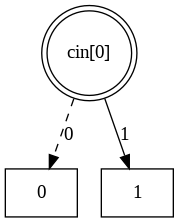

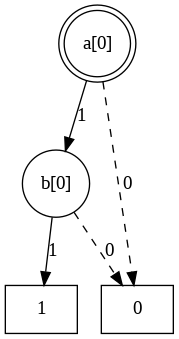

In [ ]:
!apt-get -y install graphviz > /dev/null
!dot -Tpng fa_sum_0.dot -o fa_sum_0.png
!dot -Tpng fa_cout_0.dot -o fa_cout_0.png

from IPython.display import Image, display
display(Image('fa_sum_0.png'))
display(Image('fa_cout_0.png'))


## **TESTCASE** **1**
8-bit Boolean ALU

In [ ]:
%%writefile alu8_bool.v
module alu8_bool(
  input  [7:0] a, b,
  input  [2:0] op,      // 0..7 selects the operation
  output [7:0] y,
  output       zf,      // zero flag
  output       nf       // negative flag (MSB)
);
  // Decode (no '=='): one-hot via minterms
  wire d0 = (~op[2] & ~op[1] & ~op[0]);
  wire d1 = (~op[2] & ~op[1] &  op[0]);
  wire d2 = (~op[2] &  op[1] & ~op[0]);
  wire d3 = (~op[2] &  op[1] &  op[0]);
  wire d4 = ( op[2] & ~op[1] & ~op[0]);
  wire d5 = ( op[2] & ~op[1] &  op[0]);
  wire d6 = ( op[2] &  op[1] & ~op[0]);
  wire d7 = ( op[2] &  op[1] &  op[0]);

  // IMPORTANT: use separate assigns (no init in decls)
  wire [7:0] y0; assign y0 = (a & b);    // AND
  wire [7:0] y1; assign y1 = (a | b);    // OR
  wire [7:0] y2; assign y2 = (a ^ b);    // XOR
  wire [7:0] y3; assign y3 = ~(a ^ b);   // XNOR
  wire [7:0] y4; assign y4 = ~(a & b);   // NAND
  wire [7:0] y5; assign y5 = ~(a | b);   // NOR
  wire [7:0] y6; assign y6 = a;          // PASS A
  wire [7:0] y7; assign y7 = ~a;         // NOT A

  // Vector mux (bitwise)
  assign y =
      d0 ? y0 :
      d1 ? y1 :
      d2 ? y2 :
      d3 ? y3 :
      d4 ? y4 :
      d5 ? y5 :
      d6 ? y6 :
           y7 ;

  // Flags (no reduction ops; manual OR tree)
  wire o01 = (y[0] | y[1]);
  wire o23 = (y[2] | y[3]);
  wire o45 = (y[4] | y[5]);
  wire o67 = (y[6] | y[7]);
  wire o03 = (o01 | o23);
  wire o47 = (o45 | o67);
  wire any = (o03 | o47);

  assign zf = ~any;   // zero when no bit set
  assign nf =  y[7];  // sign = MSB
endmodule


Writing alu8_bool.v


In [ ]:
!python robdd_from_verilog.py alu8_bool.v \
  --order op[0],op[1],op[2],a[0],b[0],a[1],b[1],a[2],b[2],a[3],b[3],a[4],b[4],a[5],b[5],a[6],b[6],a[7],b[7] \
  --dot alu


== ROBDD Summary ==
Inputs (bits): 19
Outputs (bits): 10  -> nf[0], y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], zf[0]
Variable order: op[0], op[1], op[2], a[0], b[0], a[1], b[1], a[2], b[2], a[3], b[3], a[4], b[4], a[5], b[5], a[6], b[6], a[7], b[7]
Unique BDD nodes (non-terminals): 80
Reachable nodes (from outputs): 8
Wrote DOT files with prefix: alu_*.dot


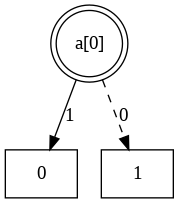

In [ ]:
!apt-get -y install graphviz > /dev/null
!dot -Tpng alu_y_0.dot -o alu_y_0.png
from IPython.display import Image, display
display(Image('alu_y_0.png'))


## **TESTCASE 2**
**8-bit Add/Sub (ripple)**

In [ ]:
%%writefile addsub8_ripple.v
module addsub8_ripple(
  input  [7:0] a, b,
  input        sub,        // 0: add, 1: subtract (a + ~b + 1)
  output [7:0] sum,
  output       cout,
  output       ovf,
  output       zf,
  output       nf
);
  // b ⊕ sub (bitwise), declared with separate assigns
  wire bx0; assign bx0 = b[0] ^ sub;
  wire bx1; assign bx1 = b[1] ^ sub;
  wire bx2; assign bx2 = b[2] ^ sub;
  wire bx3; assign bx3 = b[3] ^ sub;
  wire bx4; assign bx4 = b[4] ^ sub;
  wire bx5; assign bx5 = b[5] ^ sub;
  wire bx6; assign bx6 = b[6] ^ sub;
  wire bx7; assign bx7 = b[7] ^ sub;

  // ripple chain (g/p form): c_{i+1} = g_i | (p_i & c_i)
  wire c0; assign c0 = sub;

  wire s0; assign s0 = (a[0] ^ bx0) ^ c0;
  wire g0; assign g0 = (a[0] & bx0);
  wire p0; assign p0 = (a[0] ^ bx0);
  wire c1; assign c1 = (g0) | (p0 & c0);

  wire s1; assign s1 = (a[1] ^ bx1) ^ c1;
  wire g1; assign g1 = (a[1] & bx1);
  wire p1; assign p1 = (a[1] ^ bx1);
  wire c2; assign c2 = (g1) | (p1 & c1);

  wire s2; assign s2 = (a[2] ^ bx2) ^ c2;
  wire g2; assign g2 = (a[2] & bx2);
  wire p2; assign p2 = (a[2] ^ bx2);
  wire c3; assign c3 = (g2) | (p2 & c2);

  wire s3; assign s3 = (a[3] ^ bx3) ^ c3;
  wire g3; assign g3 = (a[3] & bx3);
  wire p3; assign p3 = (a[3] ^ bx3);
  wire c4; assign c4 = (g3) | (p3 & c3);

  wire s4; assign s4 = (a[4] ^ bx4) ^ c4;
  wire g4; assign g4 = (a[4] & bx4);
  wire p4; assign p4 = (a[4] ^ bx4);
  wire c5; assign c5 = (g4) | (p4 & c4);

  wire s5; assign s5 = (a[5] ^ bx5) ^ c5;
  wire g5; assign g5 = (a[5] & bx5);
  wire p5; assign p5 = (a[5] ^ bx5);
  wire c6; assign c6 = (g5) | (p5 & c5);

  wire s6; assign s6 = (a[6] ^ bx6) ^ c6;
  wire g6; assign g6 = (a[6] & bx6);
  wire p6; assign p6 = (a[6] ^ bx6);
  wire c7; assign c7 = (g6) | (p6 & c6);

  wire s7; assign s7 = (a[7] ^ bx7) ^ c7;
  wire g7; assign g7 = (a[7] & bx7);
  wire p7; assign p7 = (a[7] ^ bx7);
  wire c8; assign c8 = (g7) | (p7 & c7);

  // outputs (no {} concat — assign per bit)
  assign sum[0]=s0; assign sum[1]=s1; assign sum[2]=s2; assign sum[3]=s3;
  assign sum[4]=s4; assign sum[5]=s5; assign sum[6]=s6; assign sum[7]=s7;

  assign cout = c8;
  assign ovf  = c7 ^ c8;  // signed overflow

  // zero flag via OR-tree (no reduction operator)
  wire o01; assign o01 = (s0 | s1);
  wire o23; assign o23 = (s2 | s3);
  wire o45; assign o45 = (s4 | s5);
  wire o67; assign o67 = (s6 | s7);
  wire o03; assign o03 = (o01 | o23);
  wire o47; assign o47 = (o45 | o67);
  wire any; assign any = (o03 | o47);

  assign zf = ~any;
  assign nf =  s7;
endmodule


Writing addsub8_ripple.v


In [ ]:
!python robdd_from_verilog.py addsub8_ripple.v \
  --order sub[0],a[0],b[0],a[1],b[1],a[2],b[2],a[3],b[3],a[4],b[4],a[5],b[5],a[6],b[6],a[7],b[7] \
  --dot addsub


== ROBDD Summary ==
Inputs (bits): 17
Outputs (bits): 12  -> cout[0], nf[0], ovf[0], sum[0], sum[1], sum[2], sum[3], sum[4], sum[5], sum[6], sum[7], zf[0]
Variable order: sub[0], a[0], b[0], a[1], b[1], a[2], b[2], a[3], b[3], a[4], b[4], a[5], b[5], a[6], b[6], a[7], b[7]
Unique BDD nodes (non-terminals): 1056
Reachable nodes (from outputs): 327
Wrote DOT files with prefix: addsub_*.dot


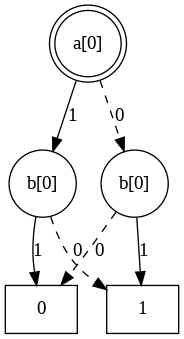

In [ ]:
!apt-get -y install graphviz > /dev/null
!dot -Tpng addsub_sum_0.dot -o addsub_sum_0.png
from IPython.display import Image, display
display(Image('addsub_sum_0.png'))


# **TSESTCASE 3**
**16-bit Priority Encoder**

In [ ]:
%%writefile prienc16.v
module prienc16(
  input  [15:0] in,
  output [3:0]  idx,   // index of highest '1' (15 highest)
  output        valid  // 1 if any bit set
);
  // valid = OR of all inputs (no reduction op; all with assigns)
  wire o15_14; assign o15_14 = (in[15] | in[14]);
  wire o13_12; assign o13_12 = (in[13] | in[12]);
  wire o11_10; assign o11_10 = (in[11] | in[10]);
  wire o09_08; assign o09_08 = (in[9]  | in[8]);
  wire o07_06; assign o07_06 = (in[7]  | in[6]);
  wire o05_04; assign o05_04 = (in[5]  | in[4]);
  wire o03_02; assign o03_02 = (in[3]  | in[2]);
  wire o01_00; assign o01_00 = (in[1]  | in[0]);

  wire o15_12; assign o15_12 = (o15_14 | o13_12);
  wire o11_08; assign o11_08 = (o11_10 | o09_08);
  wire o07_04; assign o07_04 = (o07_06 | o05_04);
  wire o03_00; assign o03_00 = (o03_02 | o01_00);

  wire o15_08; assign o15_08 = (o15_12 | o11_08);
  wire o07_00; assign o07_00 = (o07_04 | o03_00);

  assign valid = (o15_08 | o07_00);

  // MSB-first priority via nested ternaries; 4-bit constants are fine
  assign idx =
      in[15] ? 4'b1111 :
      in[14] ? 4'b1110 :
      in[13] ? 4'b1101 :
      in[12] ? 4'b1100 :
      in[11] ? 4'b1011 :
      in[10] ? 4'b1010 :
      in[9]  ? 4'b1001 :
      in[8]  ? 4'b1000 :
      in[7]  ? 4'b0111 :
      in[6]  ? 4'b0110 :
      in[5]  ? 4'b0101 :
      in[4]  ? 4'b0100 :
      in[3]  ? 4'b0011 :
      in[2]  ? 4'b0010 :
      in[1]  ? 4'b0001 :
      in[0]  ? 4'b0000 :
               4'b0000 ; // don't-care when valid=0
endmodule


Writing prienc16.v


In [ ]:
# LSB→MSB
!python robdd_from_verilog.py prienc16.v \
  --order in[0],in[1],in[2],in[3],in[4],in[5],in[6],in[7],in[8],in[9],in[10],in[11],in[12],in[13],in[14],in[15] \
  --dot pe_lsb

# MSB→LSB (often worse for this encoding — great for a size comparison in your report)
!python robdd_from_verilog.py prienc16.v \
  --order in[15],in[14],in[13],in[12],in[11],in[10],in[9],in[8],in[7],in[6],in[5],in[4],in[3],in[2],in[1],in[0] \
  --dot pe_msb


== ROBDD Summary ==
Inputs (bits): 16
Outputs (bits): 5  -> idx[0], idx[1], idx[2], idx[3], valid[0]
Variable order: in[0], in[1], in[2], in[3], in[4], in[5], in[6], in[7], in[8], in[9], in[10], in[11], in[12], in[13], in[14], in[15]
Unique BDD nodes (non-terminals): 315
Reachable nodes (from outputs): 50
Wrote DOT files with prefix: pe_lsb_*.dot
== ROBDD Summary ==
Inputs (bits): 16
Outputs (bits): 5  -> idx[0], idx[1], idx[2], idx[3], valid[0]
Variable order: in[15], in[14], in[13], in[12], in[11], in[10], in[9], in[8], in[7], in[6], in[5], in[4], in[3], in[2], in[1], in[0]
Unique BDD nodes (non-terminals): 82
Reachable nodes (from outputs): 65
Wrote DOT files with prefix: pe_msb_*.dot


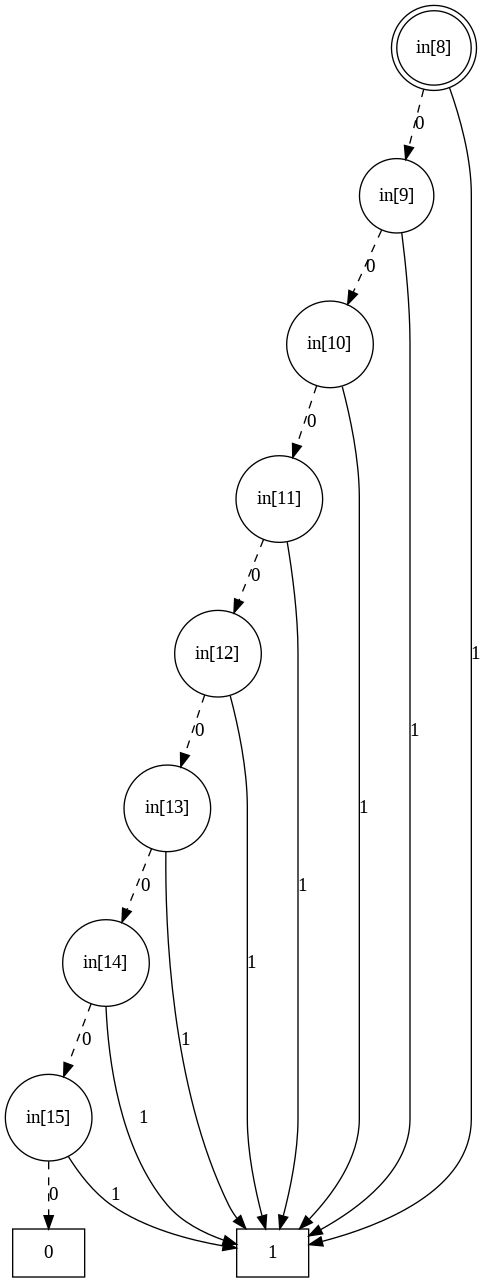

In [ ]:
!apt-get -y install graphviz > /dev/null
!dot -Tpng pe_lsb_idx_3.dot -o pe_lsb_idx_3.png
from IPython.display import Image, display
display(Image('pe_lsb_idx_3.png'))
